# IEEE grids for testing the synthetic grid topology generation

In [1]:
import pandapower as pp
import pandapower.networks as pn
import pandas as pd
import numpy as np
import os
import sys
import networkx as nx
import matplotlib.pyplot as plt

from powergrid_synth.generator import PowerGridGenerator
from powergrid_synth.bus_type_allocator import BusTypeAllocator
from powergrid_synth.comparison import GraphComparator
from powergrid_synth.visualization import GridVisualizer
from powergrid_synth.capacity_allocator import CapacityAllocator
from powergrid_synth.load_allocator import LoadAllocator
from powergrid_synth.generation_dispatcher import GenerationDispatcher
from powergrid_synth.transmission import TransmissionLineAllocator


from powergrid_synth.data_format_converter import pandapower_to_nx
from powergrid_synth.input_extractor import extract_topology_params_from_graph
    
from pandapower.topology.create_graph import create_nxgraph

/usr/local/anaconda3/lib/python3.9/site-packages/pandas/core/computation/expressions.py:21: UserWarning: Pandas requires version '2.8.4' or newer of 'numexpr' (version '2.7.3' currently installed).
  from pandas.core.computation.check import NUMEXPR_INSTALLED
/usr/local/anaconda3/lib/python3.9/site-packages/pandas/core/arrays/masked.py:61: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.2' currently installed).
  from pandas.core import (


SystemError: initialization of _internal failed without raising an exception

### Load an IEEE grid using pandapower

In [ ]:
# 1. Load Real IEEE Grid and Convert
print("\n[1] Loading Reference Grid (IEEE)...")
net_real = pn.case118()
graph_real = pandapower_to_nx(net_real)
# graph_real = create_nxgraph(net_real, respect_switches = False)

print(f"Loaded {graph_real.number_of_nodes()} nodes and {graph_real.number_of_edges()} edges.")



[1] Loading Reference Grid (IEEE)...
Loaded 118 nodes and 179 edges.


In [ ]:
net_real

This pandapower network includes the following parameter tables:
   - bus (118 elements)
   - load (99 elements)
   - gen (53 elements)
   - shunt (14 elements)
   - ext_grid (1 element)
   - line (173 elements)
   - trafo (13 elements)
   - poly_cost (54 elements)

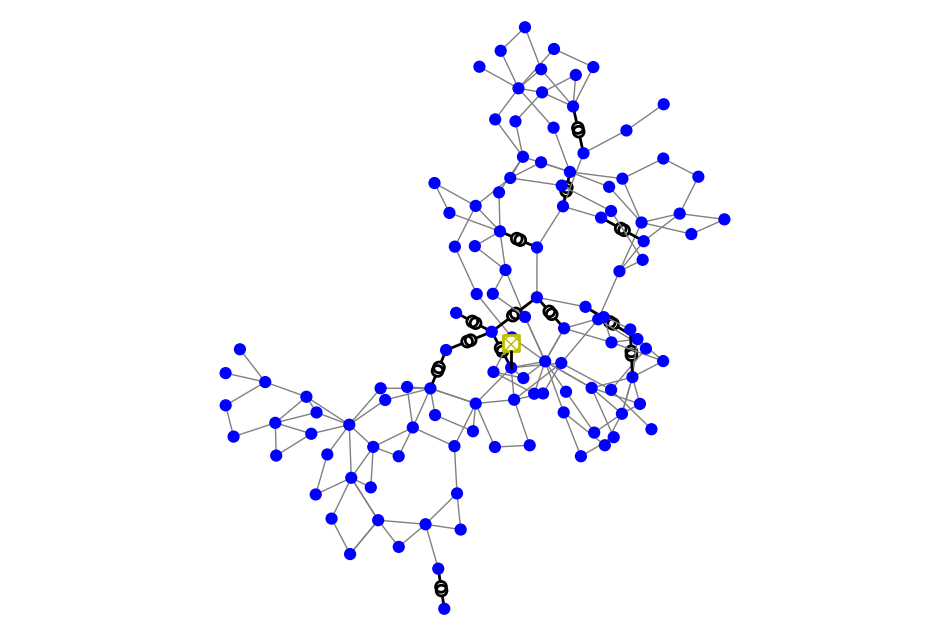

In [ ]:
fig, ax = plt.subplots(figsize=(12,8))
ax = pp.plotting.simple_plot(net_real, ax=ax)

In [ ]:
net_real.trafo

,name,std_type,hv_bus,lv_bus,sn_mva,vn_hv_kv,vn_lv_kv,vk_percent,vkr_percent,pfe_kw,...,tap_min,tap_max,tap_step_percent,tap_step_degree,tap_pos,parallel,df,in_service,max_loading_percent,tap_changer_type
0,None,None,7,4,9900.0,345.0,138.0,264.330000,0.000,0.0,...,NaN,NaN,1.5,NaN,-1.0,1,1.0,True,100.0,Ratio
1,None,None,25,24,9900.0,345.0,138.0,378.180000,0.000,0.0,...,NaN,NaN,4.0,NaN,-1.0,1,1.0,True,100.0,Ratio
2,None,None,29,16,9900.0,345.0,138.0,384.120000,0.000,0.0,...,NaN,NaN,4.0,NaN,-1.0,1,1.0,True,100.0,Ratio
3,None,None,37,36,9900.0,345.0,138.0,371.250000,0.000,0.0,...,NaN,NaN,6.5,NaN,-1.0,1,1.0,True,100.0,Ratio
4,None,None,62,58,9900.0,345.0,138.0,382.140000,0.000,0.0,...,NaN,NaN,4.0,NaN,-1.0,1,1.0,True,100.0,Ratio
5,None,None,63,60,9900.0,345.0,138.0,265.320000,0.000,0.0,...,NaN,NaN,1.5,NaN,-1.0,1,1.0,True,100.0,Ratio
6,None,None,64,65,9900.0,345.0,138.0,366.300000,0.000,0.0,...,NaN,NaN,6.5,NaN,-1.0,1,1.0,True,100.0,Ratio
7,None,None,64,67,9900.0,345.0,161.0,158.988082,13.662,0.0,...,NaN,NaN,NaN,NaN,NaN,1,1.0,True,100.0,None
8,None,None,67,68,9900.0,161.0,138.0,366.300000,0.000,0.0,...,NaN,NaN,6.5,NaN,-1.0,1,1.0,True,100.0,Ratio
9,None,None,80,67,9900.0,345.0,161.0,200.729061,17.325,0.0,...,NaN,NaN,NaN,NaN,NaN,1,1.0,True,100.0,None


## Generate a synthetic grid

### Extract Topology Characteristics from Graph

In [ ]:
print("\n[2] Analyzing Reference Topology...")
params = extract_topology_params_from_graph(graph_real)


[2] Analyzing Reference Topology...
Extracting topology parameters...


### PowerGridGenerator

In [ ]:
# 3. Generate Synthetic Grid
print("\n[3] Generating Synthetic Clone...")
gen = PowerGridGenerator(seed=53)
synthetic_graph = gen.generate_grid(
    degrees_by_level=params['degrees_by_level'],
    diameters_by_level=params['diameters_by_level'],
    transformer_degrees=params['transformer_degrees'],
    keep_lcc=True
)


[3] Generating Synthetic Clone...
--- Starting Generation for 3 Voltage Levels ---
Generating Level 0...
  -> Level 0 Complete. Nodes: 14, Edges: 9
Generating Level 1...
  -> Level 1 Complete. Nodes: 2, Edges: 0
Generating Level 2...
  -> Level 2 Complete. Nodes: 117, Edges: 143
Generating Transformer Connections...
  -> Connecting Level 0 <-> Level 1
  -> Connecting Level 0 <-> Level 2
  -> Connecting Level 1 <-> Level 2
Filtering for Largest Connected Component (LCC)...
  -> Kept 118 nodes (removed 15 isolated nodes).


## Analysis

In [ ]:
#5. Compare using the Library Module
print("\n[5] Running Comparative Analysis...")
comparator = GraphComparator(
    synth_graph=synthetic_graph, 
    ref_graph=graph_real, 
    synth_label="Synthetic", 
    ref_label="IEEE grid"
)


[5] Running Comparative Analysis...


#### Compare some metric Globally

In [ ]:
comparator.print_metric_comparison(title="GLOBAL TOPOLOGY COMPARISON")


GLOBAL TOPOLOGY COMPARISON
            Metric Synthetic IEEE grid
             Nodes       118       118
             Edges       164       179
           Density  0.023758  0.025931
        Connected?       Yes       Yes
    Diameter (LCC)        14        14
Avg Path Len (LCC)    6.3178    6.3087
    Avg Clustering    0.1350    0.1651
      Transitivity    0.1146    0.1356



#### Plot the global node degree distribution for two grids

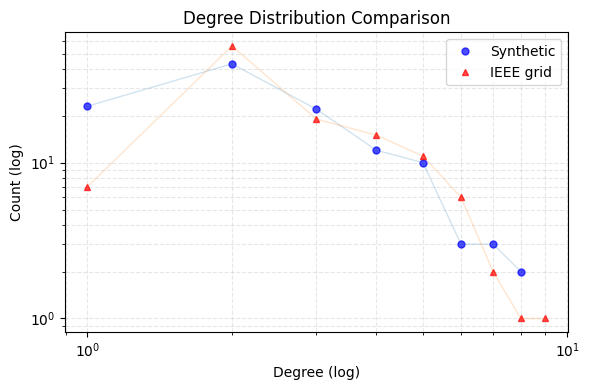

In [ ]:
comparator.plot_degree_comparison(log_scale=True, fig_size=(6,4), show_lines=True,)

#### Compare the histograms of node degrees for each voltage level

Plotting Combined Comparison Figure for 3 Levels (Log Scale: False)...


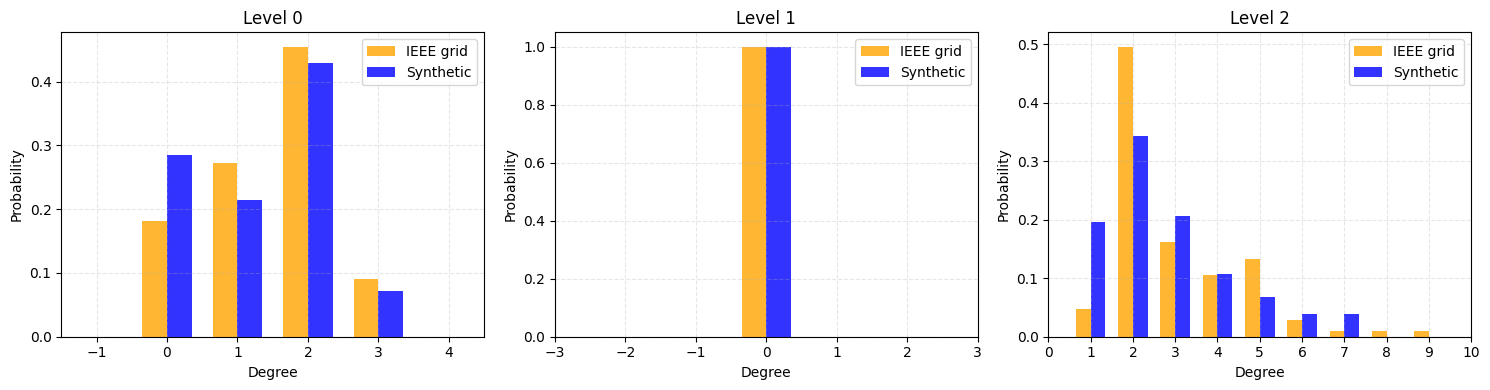

In [ ]:
comparator.plot_all_levels_comparison(False)

#### Compare other topology metrics per voltage level

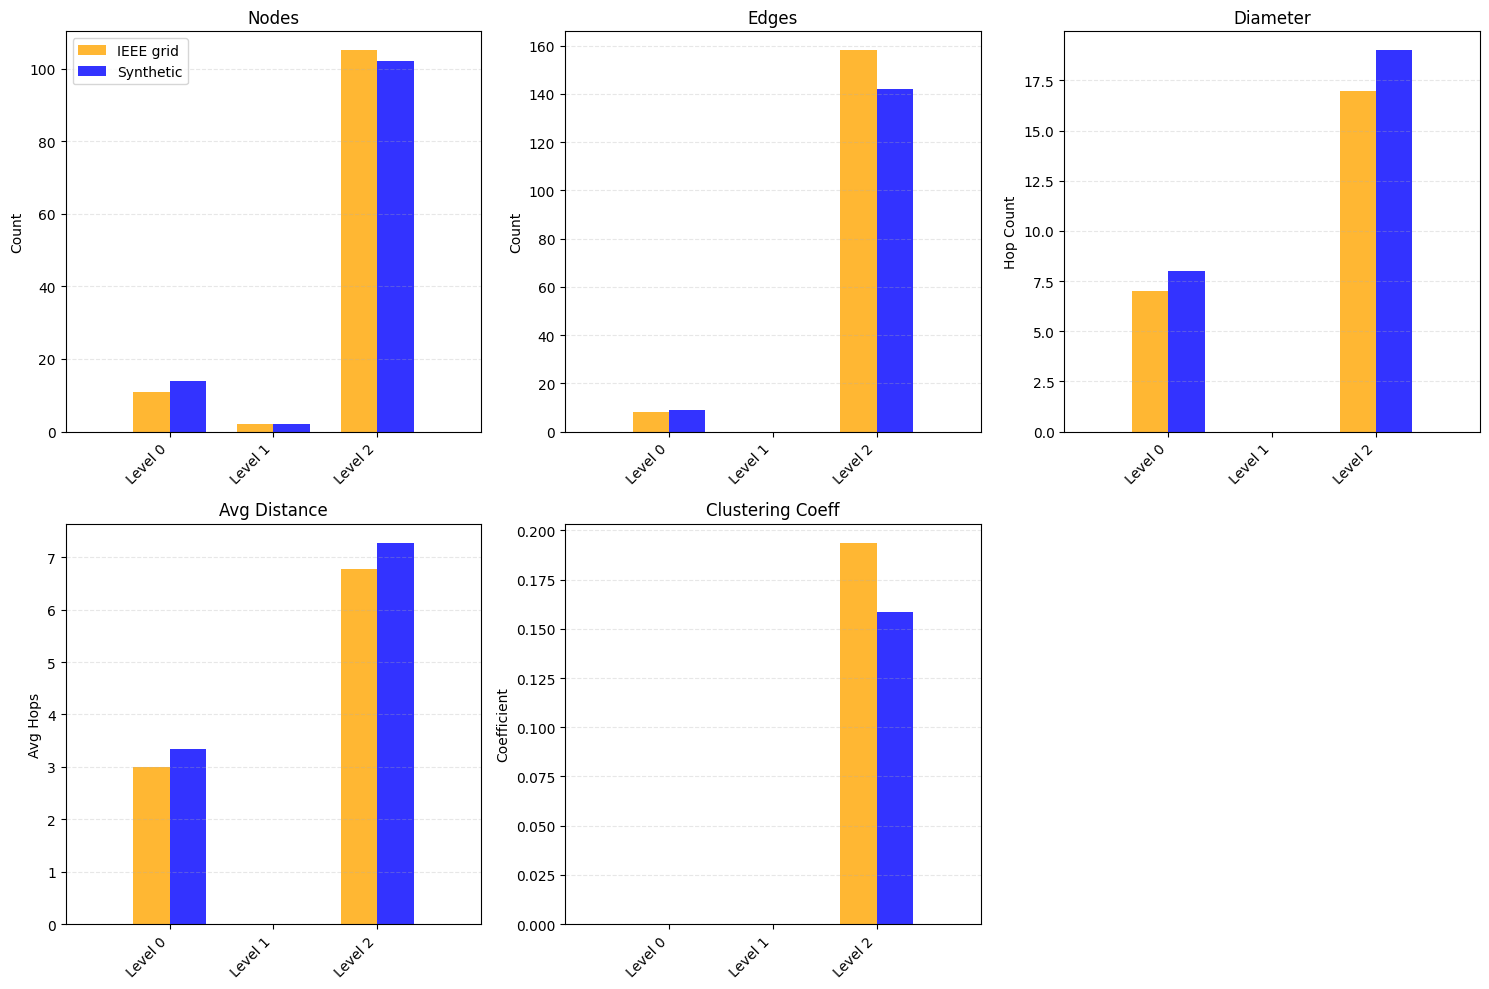

In [ ]:
comparator.plot_level_topology_comparison()

## Visualizations

In [ ]:
viz = GridVisualizer()

Calculating layout 'kamada_kawai'...


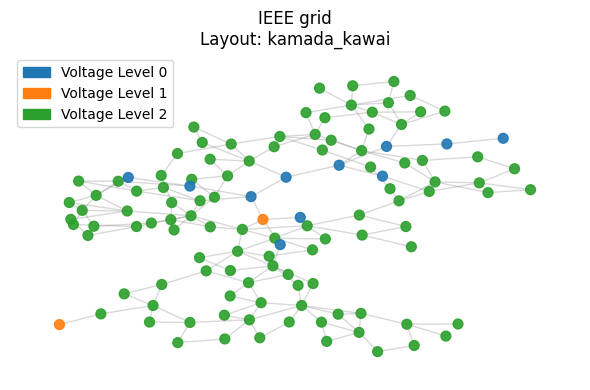

In [ ]:
viz.plot_grid(
    graph_real, 
    layout='kamada_kawai',
    title="IEEE grid",
    figsize=(6, 4)
)

Calculating layout 'kamada_kawai'...


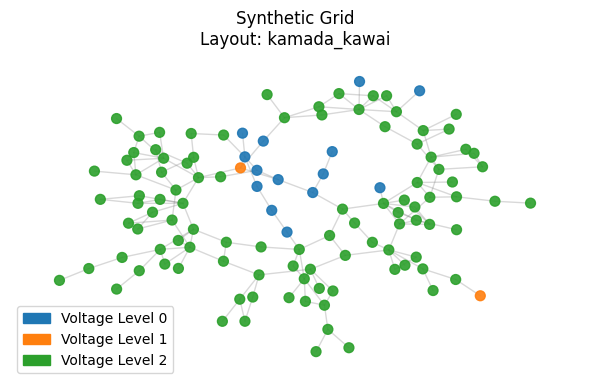

In [ ]:
viz.plot_grid(
    synthetic_graph, 
    layout='kamada_kawai',
    title="Synthetic Grid",
    figsize=(6, 4)
)

### Bus type assignment

In [ ]:
# 4. Allocate Bus Types
print("\n[4] Allocating Bus Types via AIS...")
allocator = BusTypeAllocator(synthetic_graph, entropy_model=0, bus_type_ratio=[20,60,0])
# The allocator uses the graph size to determine target ratios dynamically
bus_types = allocator.allocate(max_iter=50)
nx.set_node_attributes(synthetic_graph, bus_types, name="bus_type")


[4] Allocating Bus Types via AIS...
Starting Bus Type Allocation (N=118, M=164)...
  Target Entropy Score (W*): 1.4318, Std Dev: 0.0395
  Iter 0: Best Error = 0.004588
  Iter 10: Best Error = 0.000430
  Iter 20: Best Error = 0.000430
  Iter 30: Best Error = 0.000430
  Iter 40: Best Error = 0.000430


-----> Assignment Complete:
       Generators: 31 (26.3%)
       Loads:      87 (73.7%)
       Connectors: 0 (0.0%)

[5] Visualizing Bus Types & Edge Styles...
Calculating layout 'kamada_kawai' for bus types...


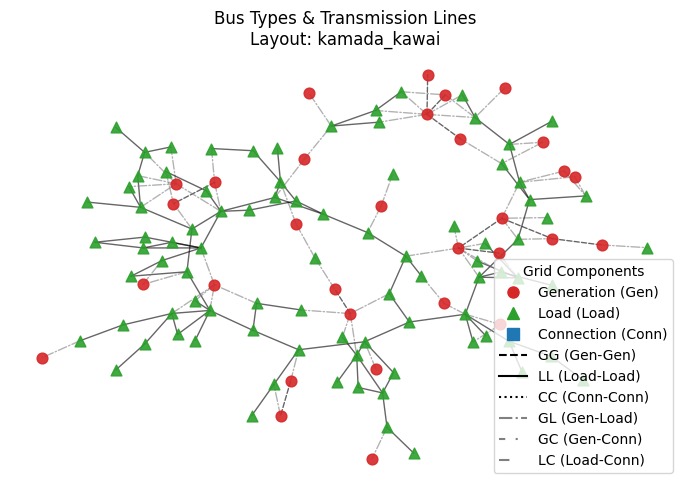

In [ ]:
from collections import Counter

counts = Counter(bus_types.values())
total = sum(counts.values())
print(f"-----> Assignment Complete:")
print(f"       Generators: {counts['Gen']} ({counts['Gen']/total:.1%})")
print(f"       Loads:      {counts['Load']} ({counts['Load']/total:.1%})")
print(f"       Connectors: {counts['Conn']} ({counts['Conn']/total:.1%})")

# --- 5. Bus Type Visualization ---
print("\n[5] Visualizing Bus Types & Edge Styles...")

# Call the new interactive method
viz.plot_bus_types(
    synthetic_graph, 
    layout='kamada_kawai', 
    title="Bus Types & Transmission Lines", 
    figsize=(7,5)
)

### Generation capacities and load settings

In [ ]:
print("\n[6] Allocating Capacity...")
cap_allocator = CapacityAllocator(synthetic_graph)
capacities = cap_allocator.allocate()
total_gen = sum(capacities.values())
print(f"Total Generation: {total_gen:.2f} MW")
# Attach to graph
nx.set_node_attributes(synthetic_graph, capacities, name="pg_max")



[6] Allocating Capacity...
Allocating Capacity for 31 generators.
Total System Capacity Target: 10631.90 MW using Reference System 1
Total Generation: 10631.90 MW


In [ ]:
# Check top 10 generators
sorted_gens = sorted(capacities.items(), key=lambda x: x[1], reverse=True)
print("\nTop 5 Generators by Capacity:")
for node, cap in sorted_gens[:5]:
    print(f"  Node {node}: {cap:.2f} MW (Degree: {synthetic_graph.degree(node)})")


Top 5 Generators by Capacity:
  Node 58: 1164.41 MW (Degree: 6)
  Node 47: 1057.25 MW (Degree: 8)
  Node 84: 994.38 MW (Degree: 1)
  Node 110: 738.73 MW (Degree: 1)
  Node 44: 718.98 MW (Degree: 5)


In [ ]:
print("\n[7] Allocating Loads ...")
load_allocator = LoadAllocator(synthetic_graph, ref_sys_id=1)
loads = load_allocator.allocate(loading_level='H')

# Attach to graph (attribute 'pl' for active power load)
nx.set_node_attributes(synthetic_graph, loads, name="pl")

total_load = sum(loads.values())
print(f"Total Load: {total_load:.2f} MW")

print(f"System Loading: {total_load/total_gen:.1%}")


[7] Allocating Loads ...
Allocating Loads for 87 load buses.
Total System Load Target: 8462.98 MW (Level: H)
Total Load: 8462.98 MW
System Loading: 79.6%


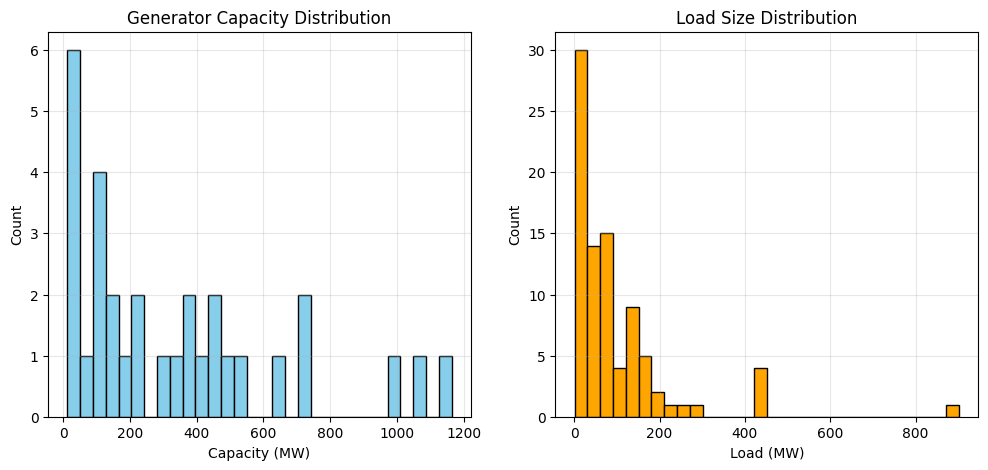

In [ ]:
# Plot Distribution
load_vals = list(loads.values())

if load_vals:
    plt.figure(figsize=(12, 5))
    
    plt.subplot(1, 2, 2)
    plt.hist(load_vals, bins=30, color='orange', edgecolor='black')
    plt.title("Load Size Distribution")
    plt.xlabel("Load (MW)")
    plt.ylabel("Count")
    plt.grid(True, alpha=0.3)
    
# Plot Distribution
caps = list(capacities.values())
if caps:
    plt.subplot(1, 2, 1)
    plt.hist(caps, bins=30, color='skyblue', edgecolor='black')
    plt.title("Generator Capacity Distribution")
    plt.xlabel("Capacity (MW)")
    plt.ylabel("Count")
    plt.grid(True, alpha=0.3)
    plt.show()